In [111]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import OneHotEncoder


# To set up a temporary directory for caching pipeline results
from tempfile import mkdtemp

# To build a pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# To do a cross-validated grid search
from sklearn.model_selection import GridSearchCV

In [230]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
import tempfile
from tempfile import mkdtemp

In [2]:
from functions import *

In [396]:
df_rem=pd.read_csv('../data/interim/df_rem.csv',index_col=0)
df_test=pd.read_csv('../data/interim/df_test.csv',index_col=0)

* [ ] For each georaphy, we would want to census

---
**Dataframge Shape Aim:**
| `Census Tract_Year` | Mean Income Percentage Variation from the City Average (from year x to x+n) : Change Combined | Mean Income in Year x | Numerical X Feature 1 (from year x-t to x)|
| --- | --- | --- | --- |
| 10100_2021 | XXX |XXX |XXX |
| 10100_2020 | XXX |XXX |XXX |
| 10100_2019 | XXX |XXX |XXX |
| --- | --- | --- |--- |

  **Census Tract -- Year -- Median Income for this year**

(Median_Income_year_(x+n) - Median_Income_year_(x))*(Median_Income_year_(x+n) / Median_Income_year_(x))**2

---
**<center><h3>Baseline Classification Model<center><h3>**

* OHE:
  * Fit & transform on train
  * Transform only on test
  * `All columns are numeric`
* Group by Census Tract & Year
* Determine intial train and prediction windows
  * Baseline model: split at 2013
    * training on 2006 to 2013 data
    * predicting from 2013 to 2021
* Split X and y

---
* **OHE**

In [401]:
ohe_col=list(df_rem.drop(columns='WORK_DESCRIPTION').select_dtypes(include=['object']).columns)
ohe_col

['PERMIT_TYPE',
 'REVIEW_TYPE',
 'CONTACT_1_TYPE',
 'CONTACT_1_CITY',
 'CONTACT_1_STATE']

In [402]:
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

* Custom Column Transformer: One Hot Encoding that returns a whole dataframe with column names and one hot encoded column dropped

In [403]:
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, **kwargs):
        self.encoder = OneHotEncoder(**kwargs)
    
    def fit(self, X, y=None):
        self.encoder.fit(X[ohe_col])
        return self
    
    def transform(self, X):
        transformed_data = self.encoder.transform(X[ohe_col])
        column_names = self.encoder.get_feature_names_out()
        df = pd.DataFrame(transformed_data.toarray(), columns=column_names)
        df=pd.concat([X,df],axis=1)
        df = df.drop(columns=ohe_col)
        return df

    def get_feature_names(self, X):
        ohe_feature_names = self.encoder.get_feature_names().tolist()
        return ohe_feature_names

* `Function Transformer 2`: Grouping by Census Tract and Year
  * based on the year we are making the prediction from and the training length

In [110]:
def df_window_multi_type(df,year,t):

    '''
    Combines descriptions & numeric data
    '''
    #copy dataframe to avoid accidental overwriting
    df_temp=df.copy()

    #Confirm that no columns are set as indexs (eg. if census_tract was set as index, would cause issues)
    assert df_temp.index.is_monotonic_increasing, 'Check Indexing: Should be a simple arithmetic sequence'

    #Set 'Census_Tract' as index
    df_temp=df_temp.set_index('Census_Tract')

    #select relevant years
    #year+1 as the range end to esnure data for the current year is also included
    #drop YEAR column as we no longer need it
    df_temp=df_temp[df_temp['YEAR'].isin(range(year-t,year+1))].drop(columns='YEAR')

    #instantiate the output dataframe
    df_result=pd.DataFrame()

    #select columns with distriptions
    obj_cols = df_temp.select_dtypes(include=['object']).columns
    num_cols = df_temp.select_dtypes(include=['number']).columns

    ### CAN ADD MORE FEATURES HERE ###

    #Taking averages for numeric columns
    for col in num_cols:
        df_result[col]=df_temp.groupby(level=0)[col].mean()

    #Concatenating qualitative columns
    for col in obj_cols:
        #need to keep in mind that some stings (descriptions) might be missing
        df_result[col]=df_temp.groupby(level=0)[col].apply(lambda x: ' '.join(str(i) for i in x))

    return df_result

In [216]:
#set up a FunctionTransformer based on df_window_multi_type
grouping_transformer = FunctionTransformer(df_window_multi_type, kw_args={'year': year, 't': train_period})

* `Custom Transformer 3`: Convert income data into a Binary Target Column calculating if gentrification occured
  * based on the year we are making the prediction from and the prediction length

In [672]:
class GentrificationTarget(BaseEstimator, TransformerMixin):
    def __init__(self,year,prediction_period):
        self.year=year
        self.prediction_period=prediction_period
        self.current_income_col=None
        self.future_income_col=None
        self.median_change=None

    def fit(self,df,y=None):

        #name of the column containing income for the current year
        self.current_income_col='Median_Income_'+str(self.year)

        #the year we are making the prediction for
        prediction_year=self.year+self.prediction_period

        #name of the column containing income for the year we are making the prediction for
        self.future_income_col='Median_Income_'+str(prediction_year)

        current_income=df[self.current_income_col]
        future_income=df[self.future_income_col]

        absolute_change=future_income-current_income
        percentage_change=future_income/current_income
        combined_change=absolute_change*(percentage_change)**2

        #fitting in our case is just finding the mean change
        self.median_change=np.median(combined_change)
        #returning self with updated attributes that can be accessed in the transform method later
        return self

    def transform(self, df, y=None):
        #this method transforms the existing dataframe to calculate if the change for each geography was more or less than the mean
        #dropping all the other columns

        df_temp=df.copy()

        current_income=df[self.current_income_col]
        future_income=df[self.future_income_col]

        absolute_change=future_income-current_income
        percentage_change=future_income/current_income
        combined_change=absolute_change*(percentage_change)**2

        #this is y_target column as a list
        target=[1 if i>self.median_change else 0 for i in combined_change]

        y_col=[col for col in list(df_temp.columns) if bool(re.search('Median',col))]
        df_temp=df_temp.drop(columns=y_col)
        df_temp['Income']=current_income
        df_temp['Target']=target

        return df_temp

* `Function Transformer 4`: Split X and y columns

In [675]:
def select_columns(df):
    X = df.drop(columns='Target')
    y = df['Target']
    return X, y

In [676]:
year=2015
train_period=5
prediction_period=5

X_y_prep_baseline = Pipeline(
    [
    #one hot encoding
    ('ohe', CustomOneHotEncoder()),
    #grouping based on the year we are making the prediction from and the training length
    ('group',FunctionTransformer(df_window_multi_type, kw_args={'year': year, 't': train_period})),
    #convert income change into y_target based on the year we are making the prediction from and the prediction length and drop the remaining of Income columns
    ('target',GentrificationTarget(year,prediction_period)),
    #split into X & y
    ('X_y_split',FunctionTransformer(select_columns))
    ])

In [677]:
model_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),   # data normalization step
    ('regressor', LogisticRegression())   # linear regression model
])

In [678]:
X_y_prep_baseline.fit(df_rem)
X_rem,y_rem=X_y_prep_baseline.transform(df_rem)
X_test,y_test=X_y_prep_baseline.transform(df_test)

X_rem=X_rem.drop(columns='WORK_DESCRIPTION')
X_test=X_test.drop(columns='WORK_DESCRIPTION')

model_pipeline.fit(X_rem,y_rem)
accuracy = model_pipeline.score(X_test, y_test)

In [680]:
print(f'Baseline model accuracy is {accuracy*100:.2f}%')

Baseline model accuracy is 60.71%


---
<center><h3>Model Development: Stacked Model <center><h3>

* Baseline Stacked Model
* Looping through different years
* Gridsearch for stacked model
* 

* Next steps: add a way to concat data given specific train and prediction periods

In [681]:
def abs_perc_change(a,b):
    '''a values for the current year = year we are making prediction from
    b values for the future year = year we are making prediction for'''
    change=(b-a)*(b/a)**2
    return round(change,4)


In [690]:
class GentrificationTarget_Stacked(BaseEstimator, TransformerMixin):
    def __init__(self,training_period,prediction_period):
        self.training_period=training_period
        self.prediction_period=prediction_period
        self.median_change=None

        #the last year we can make the prediction from = 2021 (last year in the income dataset) - prediction windows
        self.year_last_from=2021-self.prediction_period
        #range of years we can predict from. +1 to be inclusive of the last year
        self.year_from_range=range(2010,self.year_last_from+1)

    def fit(self,df,y=None):

        median_di={}

        for year_from in self.year_from_range:
            #only need Median and YEAR columns
            mask=[col for col in list(df.columns) if bool(re.search('Median',col)) or col in ['Census_Tract','YEAR']]
            df_temp=df_window_multi_type(df[mask],year_from,self.training_period)

            #name of the column containing income for the current year
            current_income_col='Median_Income_'+str(year_from)
            #the year we are making the prediction for
            prediction_year=year_from+self.prediction_period

            #name of the column containing income for the year we are making the prediction for
            future_income_col='Median_Income_'+str(prediction_year)

            current_income=df_temp[current_income_col]
            future_income=df_temp[future_income_col]

            combined_change=abs_perc_change(current_income,future_income)

            #for each year create a key:value dictionary pair
            median_di[year_from]=np.median(combined_change)

        #fitting in our case is just finding the mean change
        self.median_changes=median_di
        #returning self with updated attributes that can be accessed in the transform method later
        return self

    def transform(self, df, y=None):
        #this method transforms the existing dataframe to calculate if the change for each geography was more or less than the mean & dropping all the other columns

        #instantiate an empty df for X features
        df_result=pd.DataFrame() 


        #loop for all years less or equal to the last year we can predict from
        for year_from in self.year_from_range:

            #for each loop filter by year, average numeric columns & add concat strings for each year
            df_temp=df_window_multi_type(df,year_from,self.training_period)

            #for each loop determine the year we are predicting for
            prediction_year=year_from+self.prediction_period

            #get income for the year the prediction is made FROM
            current_income_col='Median_Income_'+str(year_from)
            current_income=df_temp[current_income_col]

            #get income for the year the prediction is made FOR
            future_income=df_temp['Median_Income_'+str(prediction_year)]

            #calculate change
            combined_change=abs_perc_change(current_income,future_income)
            
            median_temp=self.median_changes[year_from]
            target_temp=[1 if i>median_temp else 0 for i in combined_change]

            #drop all Income columns
            y_col=[col for col in list(df_temp.columns) if bool(re.search('Median',col))]
            df_temp=df_temp.drop(columns=y_col)

            #add current income column back but rename as Income (otherwise for each loop the name would be different)
            df_temp['Income']=current_income

            #add target column
            df_temp['Target']=target_temp

            #keep concating df_temp to df_result for each loop 
            df_result=pd.concat([df_result,df_temp])

        #separate into X and y
        X = df_result.drop(columns='Target')
        y = df_result['Target']

        return X,y

In [691]:
#load the list of columns from EDA that did not pass the statistical test
col_drop_li=joblib.load('../data/interim/drop_feature.pkl')

#define a function to drop columns that did not pass the statistical test
def col_drop(df):
    #ensure the input is 
    df_temp=pd.DataFrame(df)
    new_df=df_temp.drop(columns=col_drop_li)
    return new_df

In [692]:
cachedir = mkdtemp()

train_period=5
prediction_period=5

X_y_prep_stacked = Pipeline(
    [
    #one hot encoding
    ('ohe', CustomOneHotEncoder()),
    #drop columns that did not pass statistical test,
    ('col_drop',FunctionTransformer(col_drop)),
    #convert income change into y_target based on the year we are making the prediction from and the prediction length and drop the remaining of Income columns
    ('target',GentrificationTarget_Stacked(train_period,prediction_period))
    ],
    memory=cachedir)

In [693]:
model_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),   # data normalization step
    ('model', LogisticRegression(max_iter=1000))   # linear regression model
])

In [694]:
X_y_prep_stacked.fit(df_rem)
X_rem,y_rem=X_y_prep_stacked.transform(df_rem)
X_test,y_test=X_y_prep_stacked.transform(df_test)

X_rem=X_rem.drop(columns='WORK_DESCRIPTION')
X_test=X_test.drop(columns='WORK_DESCRIPTION')

model_pipeline.fit(X_rem,y_rem)
accuracy = model_pipeline.score(X_test, y_test)

c:\Users\44742\anaconda3\lib\site-packages\sklearn\pipeline.py:348: UserWarning: Persisting input arguments took 8.69s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
c:\Users\44742\anaconda3\lib\site-packages\sklearn\pipeline.py:348: UserWarning: Persisting input arguments took 2.27s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transfor

In [697]:
print(f'Stacked model accuracy is {accuracy*100:.2f}%')

Stacked model accuracy is 62.32%


***
**Check for multocliinearity**

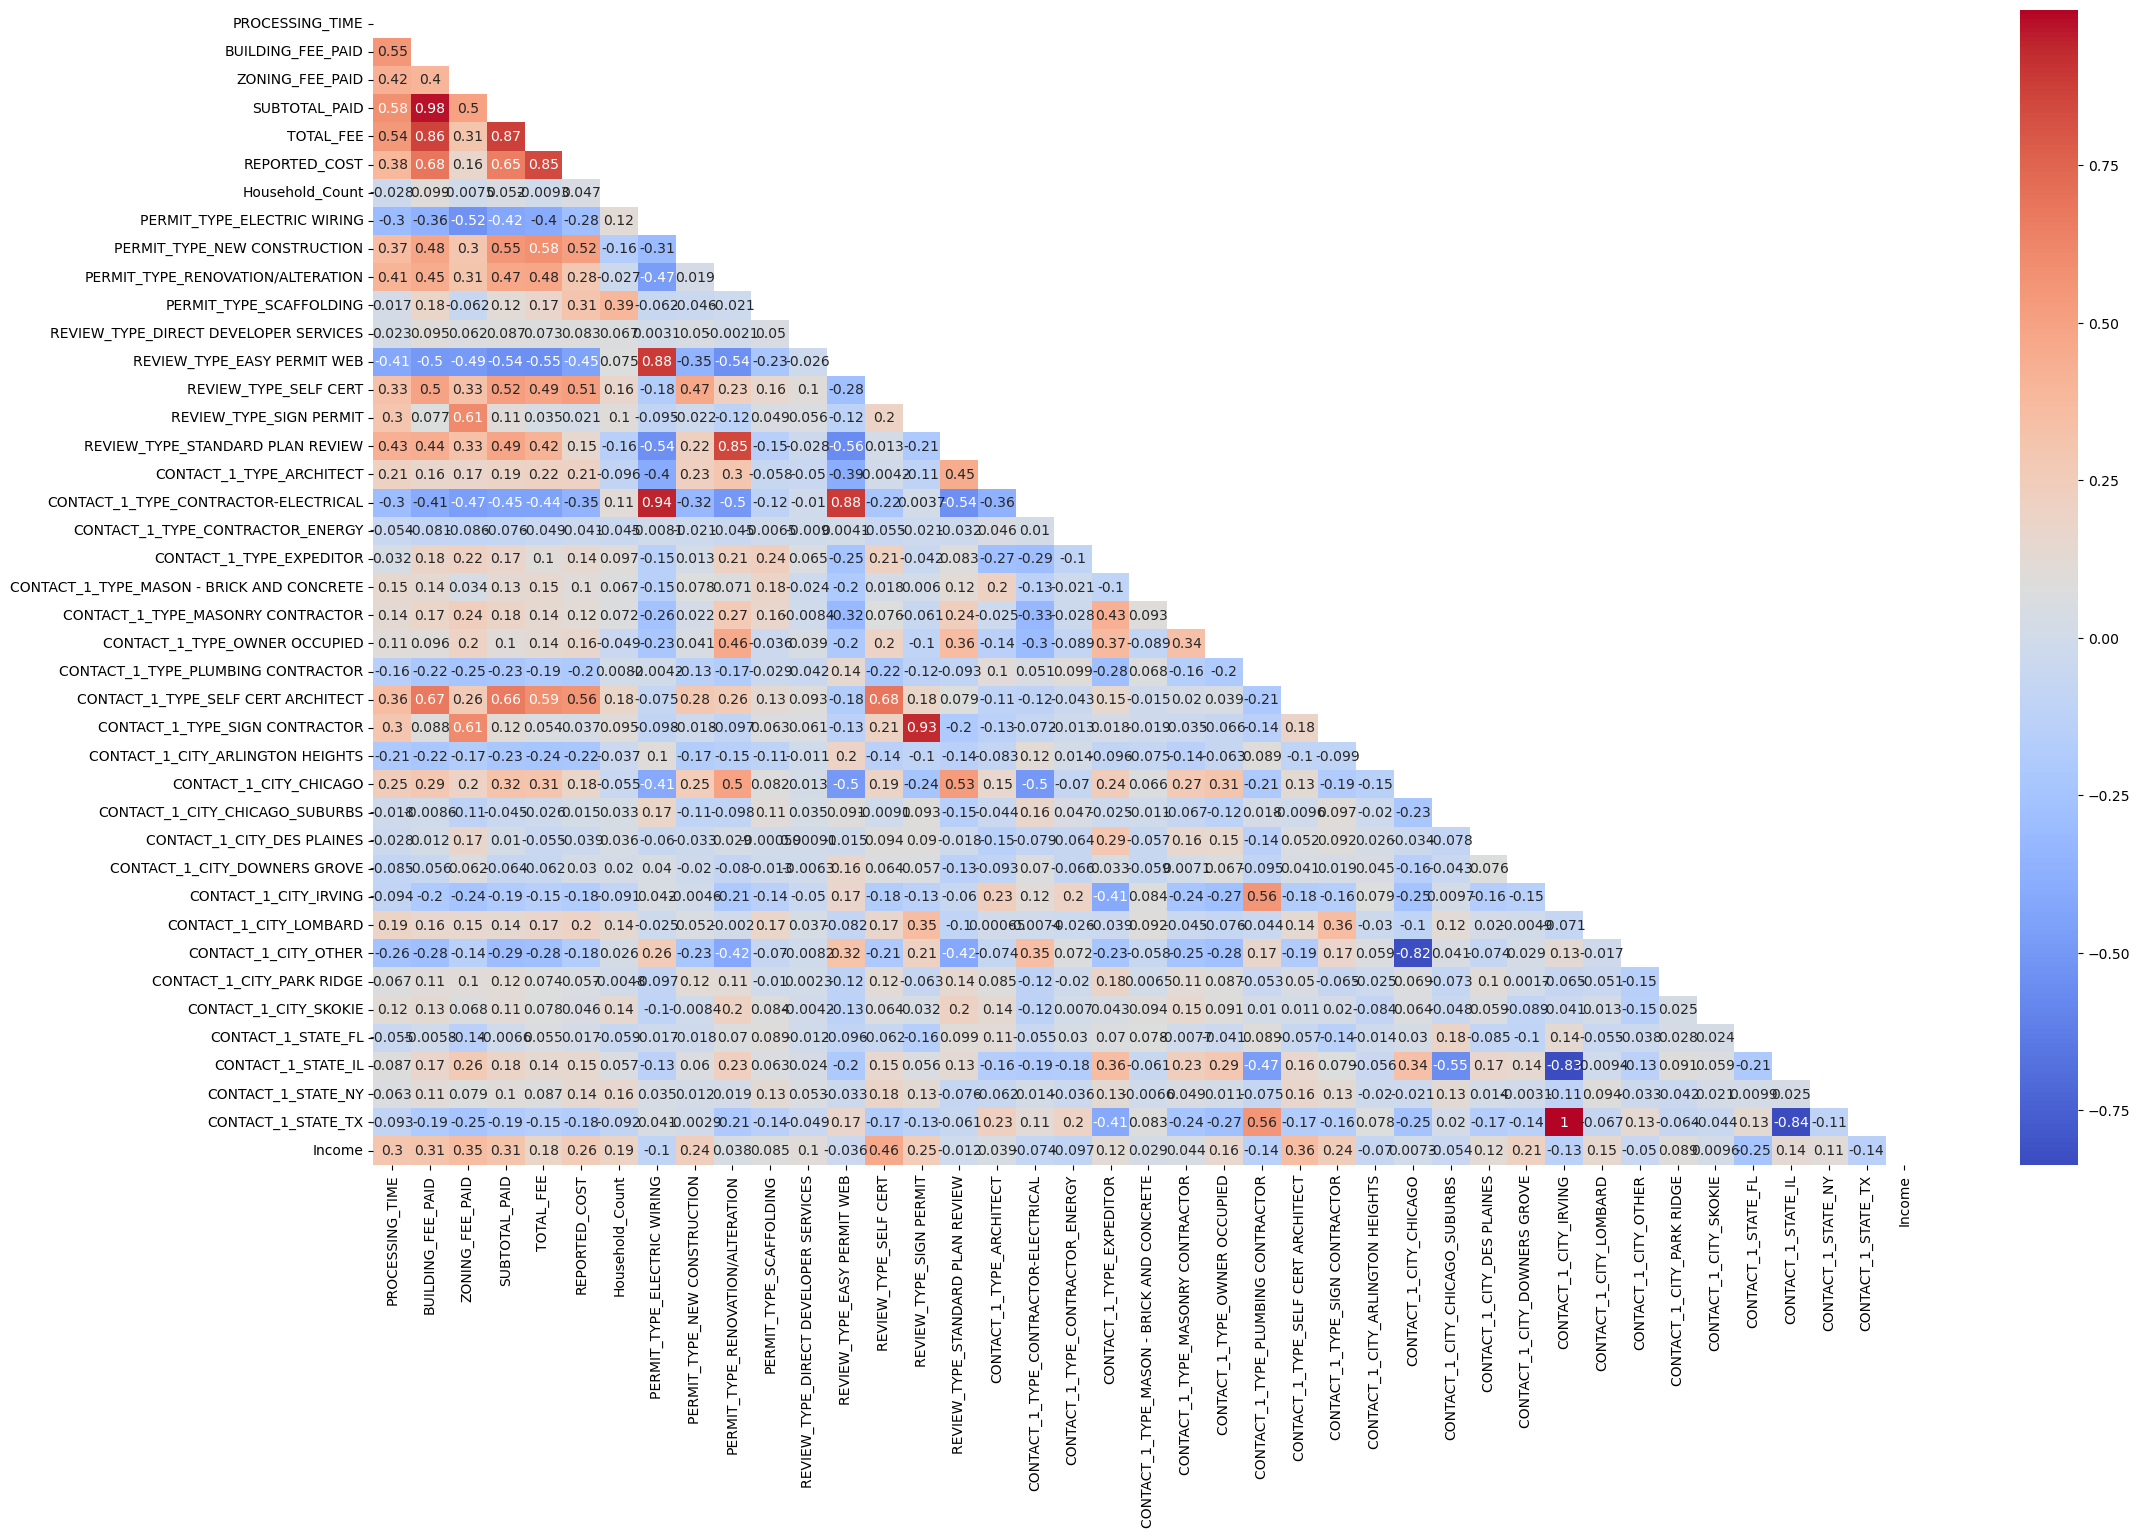

In [698]:
ind_corr=X_rem.corr()
plt.figure(figsize=(25, 15))
matrix2 = np.triu(ind_corr)
sns.heatmap(ind_corr, annot=True, mask=matrix2, cmap='coolwarm')
plt.show()

In [712]:
multi_col_drop=['BUILDING_FEE_PAID','ZONING_FEE_PAID','REVIEW_TYPE_STANDARD PLAN REVIEW','CONTACT_1_TYPE_SIGN CONTRACTOR','CONTACT_1_CITY_IRVING','CONTACT_1_CITY_OTHER','REVIEW_TYPE_EASY PERMIT WEB','CONTACT_1_STATE_TX', 'SUBTOTAL_PAID','TOTAL_FEE','CONTACT_1_TYPE_SELF CERT ARCHITECT', 'CONTACT_1_TYPE_CONTRACTOR-ELECTRICAL', 'PERMIT_TYPE_SCAFFOLDING']

In [713]:
ind_corr=X_rem.drop(columns=multi_col_drop).corr()
plt.figure(figsize=(25, 15))
matrix2 = np.triu(ind_corr)
sns.heatmap(ind_corr, annot=True, mask=matrix2, cmap='coolwarm')
plt.show()

KeyError: "['BUILDING_FEE_PAID', 'ZONING_FEE_PAID', 'REVIEW_TYPE_STANDARD PLAN REVIEW', 'CONTACT_1_TYPE_SIGN CONTRACTOR', 'CONTACT_1_CITY_IRVING', 'CONTACT_1_CITY_OTHER', 'REVIEW_TYPE_EASY PERMIT WEB', 'CONTACT_1_STATE_TX', 'SUBTOTAL_PAID', 'TOTAL_FEE', 'CONTACT_1_TYPE_SELF CERT ARCHITECT', 'CONTACT_1_TYPE_CONTRACTOR-ELECTRICAL', 'PERMIT_TYPE_SCAFFOLDING'] not found in axis"

In [714]:
X_rem=X_rem.drop(columns=multi_col_drop)
X_test=X_test.drop(columns=multi_col_drop)

model_pipeline.fit(X_rem,y_rem)
accuracy = model_pipeline.score(X_test, y_test)

KeyError: "['BUILDING_FEE_PAID', 'ZONING_FEE_PAID', 'REVIEW_TYPE_STANDARD PLAN REVIEW', 'CONTACT_1_TYPE_SIGN CONTRACTOR', 'CONTACT_1_CITY_IRVING', 'CONTACT_1_CITY_OTHER', 'REVIEW_TYPE_EASY PERMIT WEB', 'CONTACT_1_STATE_TX', 'SUBTOTAL_PAID', 'TOTAL_FEE', 'CONTACT_1_TYPE_SELF CERT ARCHITECT', 'CONTACT_1_TYPE_CONTRACTOR-ELECTRICAL', 'PERMIT_TYPE_SCAFFOLDING'] not found in axis"

In [709]:
print(accuracy)

0.6454545454545455


* Applying the stacking method allowed to improve the model accuracy from

***
<center><h3>GRID SEARCH<center><h3>

In [715]:
from sklearn.model_selection import GridSearchCV, GroupKFold

* Define custom cross validation split based on the census tracts

In [716]:
# create a custom cross-validation split with 5 folds
geo_groups=X_rem.index
# create a GroupKFold object with 5 folds
gkf = GroupKFold(n_splits=5)

* Sanity Check that unique geometries are being selected

In [717]:
train_li=[]
test_li=[]
for train_index, test_index in gkf.split(X_rem, y_rem, geo_groups):
    # do something with the train and test indices
    train_li.append(train_index)
    train_li.append(test_index)

#set set intersections

* Define pipeline framework

In [718]:
model_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),   # data normalization step
    ('dim_reducer', PCA()), 
    ('model', LogisticRegression(max_iter=1000))   # linear regression model
])

In [719]:
print(X_rem.shape,y_rem.shape)

(4003, 28) (4003,)


* Define parameters to test in the grid search

In [720]:
c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000]

logreg_param_grid = [
    
# l1
    {'scaler': [StandardScaler(),MinMaxScaler()],
    'dim_reducer': [PCA()],
    'dim_reducer__n_components': [1,2,4,10,0.8,0.9,0.95,None],
    'model': [LogisticRegression(penalty='l1',solver='saga',random_state=22,n_jobs=-1,max_iter=10000)],
    'model__C': c_values,
    'model__solver': ['saga']},
    
# l2
    {'scaler': [StandardScaler(),MinMaxScaler()],
    'dim_reducer': [PCA()],
    'dim_reducer__n_components': [1,2,4,10,0.8,0.9,0.95,None],
    'model': [LogisticRegression(penalty='l2',random_state=22,n_jobs=-1,max_iter=10000)],
    'model__C': c_values,
    'model__solver': ['lbfgs']}]

* Grid search

In [721]:
# create a custom cross-validation split with 5 folds
geo_groups=X_rem.index
# create a GroupKFold object with 5 folds
gkf = GroupKFold(n_splits=5)

# Instantiate the log reg grid search
logreg_gs = GridSearchCV(
    model_pipeline,
    param_grid=logreg_param_grid,
    cv=gkf.split(X=X_rem, y=y_rem, groups=geo_groups),
    n_jobs=-1,verbose=1,return_train_score=True
    )

* Run the grid search by fitting on X and y remainder

In [722]:
tuned_logreg_gs = logreg_gs.fit(X_rem, y_rem)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


In [725]:
tuned_logreg_gs.best_score_

0.6220405742821473

In [724]:
tuned_logreg_gs.best_params_

{'dim_reducer': PCA(n_components=2),
 'dim_reducer__n_components': 2,
 'model': LogisticRegression(C=1, max_iter=10000, n_jobs=-1, random_state=22),
 'model__C': 1,
 'model__solver': 'lbfgs',
 'scaler': MinMaxScaler()}

`Best accuracy using PCA`

In [726]:
tuned_logreg_gs.score(X_test,y_test)

0.6494949494949495

In [736]:
best_pca = logreg_gs.best_estimator_.named_steps['dim_reducer']
pca_components = best_pca.components_
pca_components

array([[ 0.18747672,  0.12546167,  0.09298735, -0.14897973,  0.22406182,
         0.09766139,  0.02062662,  0.49838814,  0.10388069, -0.00070183,
        -0.01990775,  0.38622626,  0.00561865,  0.17979042,  0.11164667,
        -0.05330015, -0.08088799,  0.1495143 , -0.04113206,  0.13457185,
         0.02534671,  0.04743843,  0.05036724,  0.03520457, -0.09634406,
         0.11854754,  0.03794579,  0.56705232],
       [-0.08570931, -0.02556709, -0.03905374, -0.0859095 , -0.12077364,
         0.10627408, -0.00700092, -0.17259982, -0.18577872, -0.04849743,
        -0.00751469,  0.66483108, -0.01377   ,  0.34233982,  0.12391347,
        -0.03043401, -0.02089858,  0.20098833, -0.0321727 ,  0.15373953,
        -0.02542296, -0.08120729,  0.04161211,  0.03363115,  0.17692907,
         0.11307351, -0.0018212 , -0.44168376]])

In [737]:
len(pca_components)

2

In [738]:
X_rem.columns

Index(['PROCESSING_TIME', 'REPORTED_COST', 'Household_Count',
       'PERMIT_TYPE_ELECTRIC WIRING', 'PERMIT_TYPE_NEW CONSTRUCTION',
       'PERMIT_TYPE_RENOVATION/ALTERATION',
       'REVIEW_TYPE_DIRECT DEVELOPER SERVICES', 'REVIEW_TYPE_SELF CERT',
       'REVIEW_TYPE_SIGN PERMIT', 'CONTACT_1_TYPE_ARCHITECT',
       'CONTACT_1_TYPE_CONTRACTOR_ENERGY', 'CONTACT_1_TYPE_EXPEDITOR',
       'CONTACT_1_TYPE_MASON - BRICK AND CONCRETE',
       'CONTACT_1_TYPE_MASONRY CONTRACTOR', 'CONTACT_1_TYPE_OWNER OCCUPIED',
       'CONTACT_1_TYPE_PLUMBING CONTRACTOR',
       'CONTACT_1_CITY_ARLINGTON HEIGHTS', 'CONTACT_1_CITY_CHICAGO',
       'CONTACT_1_CITY_CHICAGO_SUBURBS', 'CONTACT_1_CITY_DES PLAINES',
       'CONTACT_1_CITY_DOWNERS GROVE', 'CONTACT_1_CITY_LOMBARD',
       'CONTACT_1_CITY_PARK RIDGE', 'CONTACT_1_CITY_SKOKIE',
       'CONTACT_1_STATE_FL', 'CONTACT_1_STATE_IL', 'CONTACT_1_STATE_NY',
       'Income'],
      dtype='object')

In [740]:
component_names = [f'PC{i}' for i in range(1, len(pca_components) + 1)]
feature_names=X_rem.columns

df = pd.DataFrame(pca_components.T, columns=component_names, index=feature_names)

In [744]:
df['PC1'].sort_values(ascending=False)

Income                                       0.567052
REVIEW_TYPE_SELF CERT                        0.498388
CONTACT_1_TYPE_EXPEDITOR                     0.386226
PERMIT_TYPE_NEW CONSTRUCTION                 0.224062
PROCESSING_TIME                              0.187477
CONTACT_1_TYPE_MASONRY CONTRACTOR            0.179790
CONTACT_1_CITY_CHICAGO                       0.149514
CONTACT_1_CITY_DES PLAINES                   0.134572
REPORTED_COST                                0.125462
CONTACT_1_STATE_IL                           0.118548
CONTACT_1_TYPE_OWNER OCCUPIED                0.111647
REVIEW_TYPE_SIGN PERMIT                      0.103881
PERMIT_TYPE_RENOVATION/ALTERATION            0.097661
Household_Count                              0.092987
CONTACT_1_CITY_PARK RIDGE                    0.050367
CONTACT_1_CITY_LOMBARD                       0.047438
CONTACT_1_STATE_NY                           0.037946
CONTACT_1_CITY_SKOKIE                        0.035205
CONTACT_1_CITY_DOWNERS GROVE

In [745]:
df['PC2'].sort_values(ascending=False)

CONTACT_1_TYPE_EXPEDITOR                     0.664831
CONTACT_1_TYPE_MASONRY CONTRACTOR            0.342340
CONTACT_1_CITY_CHICAGO                       0.200988
CONTACT_1_STATE_FL                           0.176929
CONTACT_1_CITY_DES PLAINES                   0.153740
CONTACT_1_TYPE_OWNER OCCUPIED                0.123913
CONTACT_1_STATE_IL                           0.113074
PERMIT_TYPE_RENOVATION/ALTERATION            0.106274
CONTACT_1_CITY_PARK RIDGE                    0.041612
CONTACT_1_CITY_SKOKIE                        0.033631
CONTACT_1_STATE_NY                          -0.001821
REVIEW_TYPE_DIRECT DEVELOPER SERVICES       -0.007001
CONTACT_1_TYPE_CONTRACTOR_ENERGY            -0.007515
CONTACT_1_TYPE_MASON - BRICK AND CONCRETE   -0.013770
CONTACT_1_CITY_ARLINGTON HEIGHTS            -0.020899
CONTACT_1_CITY_DOWNERS GROVE                -0.025423
REPORTED_COST                               -0.025567
CONTACT_1_TYPE_PLUMBING CONTRACTOR          -0.030434
CONTACT_1_CITY_CHICAGO_SUBUR

---
### No PCA grid search for interpretability

`Best accuracy without PCA`

In [727]:
model_pipeline_no_pca = Pipeline([
    ('scaler', MinMaxScaler()),   # data normalization step
    ('model', LogisticRegression(max_iter=1000))   # linear regression model
])

In [728]:
c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000]

logreg_param_grid_no_pca = [
    
# l1
    {'scaler': [StandardScaler(),MinMaxScaler()],
    'model': [LogisticRegression(penalty='l1',solver='saga',random_state=22,n_jobs=-1,max_iter=10000)],
    'model__C': c_values,
    'model__solver': ['saga']},
    
# l2
    {'scaler': [StandardScaler(),MinMaxScaler()],
    'model': [LogisticRegression(penalty='l2',random_state=22,n_jobs=-1,max_iter=10000)],
    'model__C': c_values,
    'model__solver': ['lbfgs']}]

In [729]:
# create a custom cross-validation split with 5 folds
geo_groups=X_rem.index
# create a GroupKFold object with 5 folds
gkf = GroupKFold(n_splits=5)

# Instantiate the log reg grid search
logreg_gs_no_pca = GridSearchCV(
    model_pipeline_no_pca,
    param_grid=logreg_param_grid_no_pca,
    cv=gkf.split(X=X_rem, y=y_rem, groups=geo_groups),
    n_jobs=-1,verbose=1,return_train_score=True
    )

In [730]:
tuned_logreg_gs_no_pca = logreg_gs_no_pca.fit(X_rem, y_rem)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [731]:
tuned_logreg_gs_no_pca.best_score_

0.6170408863920099

In [754]:
tuned_logreg_gs_no_pca.best_params_

{'model': LogisticRegression(C=1, max_iter=10000, n_jobs=-1, random_state=22),
 'model__C': 1,
 'model__solver': 'lbfgs',
 'scaler': MinMaxScaler()}

### Residual

In [755]:
best_no_pca_model=logreg_gs_no_pca.best_estimator_
#best_no_pca_model.coef_

In [757]:
best_no_pca_model.coef_

AttributeError: 'Pipeline' object has no attribute 'coef_'

***
<center><h3>Adding NLP<center><h3>

* First run a NLP model by itself and investigate its residuals

* So far we have been dropping 'Work Description' Column before running the model
* Let's add it to the model

In [441]:
from sklearn.feature_extraction.text import TfidfVectorizer
import string

# import the nltk stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tag import pos_tag 
from nltk.stem import PorterStemmer

STOP_WORDS = stopwords.words('english')
STOP_WORDS.append('per')

def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listof_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in STOP_WORDS) & (len(word)>2) & (not bool(re.search('\d', word))):
            #stemmer = PorterStemmer()
            #stemmed_word = stemmer.stem(word)
            #listof_words.append(stemmed_word)
            listof_words.append(word)
        else:
            continue

    return listof_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\44742\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [464]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

class Description_Vector(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.vectorizer = TfidfVectorizer(tokenizer=my_tokenizer,min_df=0.05, max_df=0.8)
        
    def fit(self, df, y=None):
        description=df[0]['WORK_DESCRIPTION']
        self.vectorizer.fit(description)
        return self
        
    def transform(self, df, y=None):
        '''
        This methos vectorizers one columnn but returns the whole dataframe
        '''
        description=df[0]['WORK_DESCRIPTION']
        description_transformed = self.vectorizer.transform(description)
        feature_names=self.vectorizer.get_feature_names_out()
        df_vect=pd.DataFrame(description_transformed.toarray(), columns=feature_names)
        X=pd.concat([df[0].reset_index(drop=True),df_vect.reset_index(drop=True)],axis=1).drop(columns='WORK_DESCRIPTION')
        y=df[1].reset_index(drop=True)
        return X,y

In [465]:
cachedir = mkdtemp()

train_period=5
prediction_period=5

X_y_prep_new = Pipeline(
    [
    #one hot encoding
    ('ohe', CustomOneHotEncoder()),
    #drop columns that did not pass statistical test,
    #convert income change into y_target based on the year we are making the prediction from and the prediction length and drop the remaining of Income columns
    ('target',GentrificationTarget_Stacked(train_period,prediction_period)),
    ('vector',Description_Vector()),
    ],
    memory=cachedir)

In [466]:
X_y_prep_new.fit(df_rem)
X_rem,y_rem=X_y_prep_new.transform(df_rem)
X_test,y_test=X_y_prep_new.transform(df_test)

c:\Users\44742\anaconda3\lib\site-packages\sklearn\pipeline.py:348: UserWarning: Persisting input arguments took 11.34s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
c:\Users\44742\anaconda3\lib\site-packages\sklearn\pipeline.py:348: UserWarning: Persisting input arguments took 2.90s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transfo

In [467]:
model_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),   # data normalization step
    ('model', LogisticRegression(max_iter=1000))   # linear regression model
])

In [ ]:
c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000]

logreg_param_grid = [
    
    
# l2
    {'scaler': [MinMaxScaler()],
    'dim_reducer': [PCA()],
    'dim_reducer__n_components': [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,None],
    'model': [LogisticRegression(penalty='l2',random_state=22,n_jobs=-1,max_iter=10000)],
    'model__C': c_values,
    'model__solver': ['lbfgs']}]

In [472]:
model_pipeline.fit(X_rem,y_rem)
accuracy = model_pipeline.score(X_test, y_test)
print(accuracy)

0.882088433674744


***
**<center><h3>Classification Model Development<center><h3>**

In [14]:
scores_df_classification=pd.DataFrame({'prediction_ahead_window':[],'train_on_window':[],'train_score':[],'test_score':[]})
i=0
year_from=2010

#n_window loop
for n in range(1,8):
    #year_last_from - the last year for which we can try to predict given the chosen n
    year_last_from=2021-n

    #t_window loop: predicting using fata from the past 1 to 5 years
    for t in range(1,6):

        year_from=2010
        y_target=[] #instantiate y_target
        df_X_result=pd.DataFrame() #instantiate an empty df for X features
        
        #df_X - should contain only x_features, but keep median income for year_from and YEAR - drop
        #df_X=df.drop(columns=[....]) 

        while year_from<=year_last_from:

            #filter and average
            df_temp=df_window(df,year_from,t)

            #y_target
            y_target.extend(abs_income_change(df_temp,year_from,n))

            #x_features: drop columns with median, apart from 'Median_Income_' for the current year

            #Select all column containing 'Median' in the name
            y_col=[col for col in list(df_temp.columns) if bool(re.search('Median',col))]
            #Drop columns containing 'Median' in the name
            df_X=df_temp.drop(columns=y_col)

            #Create a string that is the name of the column containing income data for the year we are making the prediction from
            current_income='Median_Income_'+str(year_from) #current year

            #Add this column back the X dataframe
            df_X['Income']=df_temp[current_income]

            #for each year in the loop keeping adding new results
            df_X_result=pd.concat([df_X_result,df_X])
            
            #switch to the next year
            year_from+=1

        #CLASSIFICATION: THRESHOLD APPLICATION
        mean_change=np.median(y_target)
        y=np.array([1 if y>mean_change else 0 for y in y_target])
        X=df_X_result.reset_index()
        
        #Split data into test and train based on census tracts
 
        geo_set=set(X['Census_Tract'])
        test_len=int(len(geo_set)*0.25)

        geo_test=random.sample(list(geo_set),k=test_len)
        test_mask=X['Census_Tract'].isin(geo_test)

        y_test=y[test_mask]
        y_train=y[~test_mask]

        X_test=X[test_mask]
        X_train=X[~test_mask]

        #SCALE

        scaler=MinMaxScaler()
        X_train_scaled=scaler.fit_transform(X_train)
        X_test_scaled=scaler.transform(X_test)

        #PCA

        my_pca=PCA(n_components=3)
        X_pca_train=my_pca.fit_transform(X_train_scaled)
        X_pca_test=my_pca.transform(X_test_scaled)

        #MODEL

        my_logreg1=LogisticRegression(C=0.1,max_iter=1000,random_state=5)
        my_logreg1.fit(X_pca_train,y_train)
        train_score=my_logreg1.score(X_pca_train,y_train)
        test_score=my_logreg1.score(X_pca_test,y_test)

        scores_df_classification.loc[i]=[n,t,train_score,test_score]   
        i+=1


In [15]:
scores_df_classification.sort_values('test_score',ascending=False)

,prediction_ahead_window,train_on_window,train_score,test_score
20,5.0,1.0,0.655153,0.699752
34,7.0,5.0,0.676493,0.691537
22,5.0,3.0,0.660367,0.682770
16,4.0,2.0,0.669209,0.681686
30,7.0,1.0,0.663121,0.678738
14,3.0,5.0,0.663050,0.675558
21,5.0,2.0,0.660176,0.672935
13,3.0,4.0,0.661583,0.670013
11,3.0,2.0,0.653438,0.669866
24,5.0,5.0,0.671011,0.665045


* Predictions are better for larger n -> less datapoints
* Need to find a way to differentiate between different years
* Could be because of the volatility, but also could be because different years market behaviour differs

In [9]:
df_X

,YEAR,PROCESSING_TIME,BUILDING_FEE_PAID,ZONING_FEE_PAID,OTHER_FEE_PAID,SUBTOTAL_PAID,TOTAL_FEE,REPORTED_COST,CENSUS_TRACT,Median_Income_2020,...,CONTACT_1_TYPE_OWNER AS ARCHITECT & CONTRACTR,CONTACT_1_TYPE_OWNER AS GENERAL CONTRACTOR,CONTACT_1_TYPE_OWNER OCCUPIED,CONTACT_1_TYPE_PLUMBING CONTRACTOR,CONTACT_1_TYPE_RESIDENTAL REAL ESTATE DEV,CONTACT_1_TYPE_SELF CERT ARCHITECT,CONTACT_1_TYPE_SIGN CONTRACTOR,CONTACT_1_TYPE_STRUCTURAL ENGINEER,CONTACT_1_TYPE_TENT CONTRACTOR,CONTACT_1_TYPE_UNKNOWN
Census_Tract,,,,,,,,,,,,,,,,,,,,,
10100,2019.5,22.430778,505.626104,40.496281,2.249428,561.054863,583.764519,84149.541762,10100.0,42891.0,...,0.000000,0.026316,0.021739,0.0,0.0,0.000000,0.000000,0.010870,0.000000,0.000000
10201,2019.5,8.123848,379.978093,56.574021,2.678571,450.215985,454.903381,26338.300634,10201.0,39955.0,...,0.000000,0.000000,0.085829,0.0,0.0,0.032258,0.000000,0.008929,0.008929,0.041187
10202,2019.5,8.615187,446.414469,48.133848,3.812741,512.152574,518.413050,40145.471042,10202.0,43839.0,...,0.000000,0.050837,0.027027,0.0,0.0,0.061133,0.000000,0.074646,0.000000,0.050837
10300,2019.5,9.680060,371.170342,43.489583,1.955357,423.162902,423.162902,28745.775298,10300.0,44375.0,...,0.000000,0.102679,0.090774,0.0,0.0,0.032738,0.000000,0.023810,0.077381,0.020833
10400,2019.5,8.785714,396.127262,21.875000,0.892857,443.580476,492.608810,59262.142857,10400.0,37198.0,...,0.011905,0.047619,0.083333,0.0,0.0,0.059524,0.011905,0.011905,0.000000,0.047619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843700,2019.5,10.751773,466.987685,78.499310,2.996946,580.869423,647.840689,57180.173288,843700.0,153424.0,...,0.000000,0.035165,0.059693,0.0,0.0,0.082151,0.000000,0.029846,0.000000,0.009259
843800,2019.5,13.337428,371.008600,36.056511,5.651106,445.917269,465.810299,20052.121212,843800.0,40966.0,...,0.000000,0.101147,0.082719,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.028665
843900,2019.5,5.859307,567.725353,66.420455,7.350649,694.248390,721.986424,69252.149134,843900.0,50496.0,...,0.000000,0.044805,0.062987,0.0,0.0,0.099351,0.063636,0.027273,0.047619,0.056710


In [19]:
def compile_df(df,year_from,prediction_period):

        #last year we can make prediction from given how far we want to predict and that the last income data is from 2021
        year_last_from=2021-prediction_period
        y_target=[] #instantiate y_target
        df_X_result=pd.DataFrame() #instantiate an empty df for X features

        while year_from<=year_last_from:

                #filter and average
                df_temp=df_window(df,year_from,t)

                #y_target
                y_target.extend(abs_income_change(df_temp,year_from,n))

                #x_features: drop columns with median, apart from 'Median_Income_' for the current year
                current_income='Median_Income_'+str(year_from) #current year
                y_col=[col for col in list(df_temp.columns) if bool(re.search('Median',col))]
                df_X=df_temp.drop(columns=y_col)
                df_X['Income']=df_temp[current_income]

                #x_features: concat to the existing
                df_X_result=pd.concat([df_X_result,df_X])

                #switch to the next year
                year_from+=1

        #CLASSIFICATION: THRESHOLD APPLICATION
        mean_change=np.median(y_target)
        y=np.array([1 if y>mean_change else 0 for y in y_target])
        X=df_X_result.reset_index()

        return X,y

In [18]:
scores_df_classification=pd.DataFrame({'prediction_ahead_window':[],'train_on_window':[],'train_score':[],'test_score':[]})
i=0
year_from=2010

#n_window loop
for n in range(1,8):

    #t_window loop: predicting using fata from the past 1 to 5 years
    for t in range(1,6):

        year_from=2010
        y_target=[] #instantiate y_target
        df_X_result=pd.DataFrame() #instantiate an empty df for X features

        X,y=compile_df(df,year_from,n)
        
        #Split data into test and train based on census tracts

        geo_set=set(X['Census_Tract'])
        test_len=int(len(geo_set)*0.25)

        geo_test=random.sample(list(geo_set),k=test_len)
        test_mask=X['Census_Tract'].isin(geo_test)

        y_test=y[test_mask]
        y_train=y[~test_mask]

        X_test=X[test_mask]
        X_train=X[~test_mask]

        scaler=MinMaxScaler()
        X_train_scaled=scaler.fit_transform(X_train)
        X_test_scaled=scaler.transform(X_test)

        my_logreg1=LogisticRegression(C=0.1,max_iter=1000,random_state=5)
        my_logreg1.fit(X_train_scaled,y_train)
        train_score=my_logreg1.score(X_train_scaled,y_train)
        test_score=my_logreg1.score(X_test_scaled,y_test)

        scores_df_classification.loc[i]=[n,t,train_score,test_score]   
        i+=1

scores_df_classification.sort_values('test_score',ascending=False)

,prediction_ahead_window,train_on_window,train_score,test_score
28,6.0,4.0,0.705718,0.727794
27,6.0,3.0,0.700157,0.724461
32,7.0,3.0,0.709909,0.711560
30,7.0,1.0,0.708383,0.708089
15,4.0,1.0,0.681994,0.704380
25,6.0,1.0,0.703257,0.703704
29,6.0,5.0,0.705901,0.699531
34,7.0,5.0,0.722367,0.698092
19,4.0,5.0,0.685124,0.697707
18,4.0,4.0,0.682300,0.695258


In [11]:
scores_df_classification=pd.DataFrame({'prediction_ahead_window':[],'train_on_window':[],'train_score':[],'test_score':[]})
i=0
year_from=2010

#n_window loop
for n in range(1,8):
    #year_last_from - the last year for which we can try to predict given the chosen n
    year_last_from=2021-n

    #t_window loop: predicting using fata from the past 1 to 5 years
    for t in range(1,6):

        year_from=2010
        y_target=[] #instantiate y_target
        df_X_result=pd.DataFrame() #instantiate an empty df for X features
        
        #df_X - should contain only x_features, but keep median income for year_from and YEAR - drop
        #df_X=df.drop(columns=[....]) 

        while year_from<=year_last_from:

            #filter and average
            df_temp=df_window(df,year_from,t)

            #y_target
            y_target.extend(abs_income_change(df_temp,year_from,n))

            #x_features: drop columns with median, apart from 'Median_Income_' for the current year
            current_income='Median_Income_'+str(year_from) #current year
            y_col=[col for col in list(df_temp.columns) if bool(re.search('Median',col))]
            df_X=df_temp.drop(columns=y_col)
            df_X['Income']=df_temp[current_income]

            #x_features: concat to the existing
            df_X_result=pd.concat([df_X_result,df_X])
            
            #switch to the next year
            year_from+=1

        #CLASSIFICATION: THRESHOLD APPLICATION
        mean_change=np.median(y_target)
        y=np.array([1 if y>mean_change else 0 for y in y_target])
        X=df_X_result.reset_index()

        #break
        
        #Split data into test and train based on census tracts
 
        geo_set=set(X['Census_Tract'])
        test_len=int(len(geo_set)*0.25)

        geo_test=random.sample(list(geo_set),k=test_len)
        test_mask=X['Census_Tract'].isin(geo_test)

        y_test=y[test_mask]
        y_train=y[~test_mask]

        X_test=X[test_mask]
        X_train=X[~test_mask]

        scaler=MinMaxScaler()
        X_train_scaled=scaler.fit_transform(X_train)
        X_test_scaled=scaler.transform(X_test)

        my_logreg1=LogisticRegression(C=0.1,max_iter=1000,random_state=5)
        my_logreg1.fit(X_train_scaled,y_train)
        train_score=my_logreg1.score(X_train_scaled,y_train)
        test_score=my_logreg1.score(X_test_scaled,y_test)

        scores_df_classification.loc[i]=[n,t,train_score,test_score]   
        i+=1

scores_df_classification.sort_values('test_score',ascending=False)

,prediction_ahead_window,train_on_window,train_score,test_score
33,7.0,4.0,0.702955,0.725424
29,6.0,5.0,0.702526,0.720779
32,7.0,3.0,0.709411,0.708525
31,7.0,2.0,0.706358,0.708525
34,7.0,5.0,0.707463,0.706013
30,7.0,1.0,0.704957,0.700704
26,6.0,2.0,0.711054,0.698830
13,3.0,4.0,0.670155,0.696818
27,6.0,3.0,0.713076,0.695157
23,5.0,4.0,0.692884,0.693117


* Divergence between the years

---
**5 Years Ahead & 4 Years Before**

* Are there any patterns in the predictions that the model is getting wrong?
* `5.0---4.0---0.718170---0.741754`

To test this, let's first look at a single model, making the prediction from 2016 to 2021 (predicting 5 years ahead) and training on the data from 2012 to 2016 (training on 4 years prior)

In [19]:
help(abs_perc_income_change)

Help on function abs_perc_income_change in module functions:

abs_perc_income_change(df, year_x, n)
    year_x - current year (the year we are making the prediction from)
    n - the number of years ahead we are making the prediction



In [21]:
def coef_eval(X,model):
    return pd.DataFrame({'features':X.columns,'coeff':model.coef_[0]})
    

In [59]:
current_year=2016
train_years=5
prediction_years=4

y_target=abs_perc_income_change(df,current_year,train_years)
mean_change=np.median(y_target)
y=np.array([1 if y>mean_change else 0 for y in y_target])

df_temp=df_window(df,current_year,train_years).drop(columns=['YEAR','CENSUS_TRACT'])

y_target=abs_perc_income_change(df_temp,current_year,prediction_years)
mean_change=np.median(y_target)
y=np.array([1 if y>mean_change else 0 for y in y_target])

current_income='Median_Income_'+str(year_from) #current year
y_col=[col for col in list(df_temp.columns) if (bool(re.search('Median',col)) & (col!=current_income))]
df_X=df_temp.drop(columns=y_col)

X_train,X_test,y_train,y_test=train_test_split(df_X,y,test_size=0.3,random_state=5)

scaler=MinMaxScaler()
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

my_logreg1=LogisticRegression(C=0.001,max_iter=1000,random_state=5)
my_logreg1.fit(X_train_scaled,y_train)
print(f'Baseline train accuracy score {my_logreg1.score(X_train_scaled,y_train):.3f}%')
print(f'Baseline test accuracy score {my_logreg1.score(X_test_scaled,y_test):.3f}%')

coef_eval(df_X,my_logreg1).sort_values('coeff',ascending=False)

Baseline train accuracy score 0.619%
Baseline test accuracy score 0.638%


,features,coeff
7,Median_Income_2015,0.012786
4,SUBTOTAL_PAID,0.010764
13,PERMIT_TYPE_NEW CONSTRUCTION,0.010248
27,REVIEW_TYPE_SELF CERT,0.010148
3,OTHER_FEE_PAID,0.009593
5,TOTAL_FEE,0.009515
1,BUILDING_FEE_PAID,0.009452
53,CONTACT_1_TYPE_SELF CERT ARCHITECT,0.008743
0,PROCESSING_TIME,0.008565
50,CONTACT_1_TYPE_OWNER OCCUPIED,0.006694


In [ ]:
'''52	CONTACT_1_TYPE_RESIDENTAL REAL ESTATE DEV	0.000000
44	CONTACT_1_TYPE_MASON - CONCRETE ONLY	0.000000
43	CONTACT_1_TYPE_MASON - BRICK ONLY	0.000000
42	CONTACT_1_TYPE_MASON - BRICK AND CONCRETE	0.000000
12	PERMIT_TYPE_FOR EXTENSION OF PMT	0.000000
22	REVIEW_TYPE_DIRECT DEVELOPER SERVICES	0.000000
14	PERMIT_TYPE_PORCH CONSTRUCTION	0.000000'''

In [ ]:
# Looking back at EDA
#Let's drop these

# Merge CONTACT_1_TYPE_CONTRACTOR-WRECKING, CONTACT_1_TYPE_CONTRACTOR-ELECTRICAL, CONTACT_1_TYPE_CONTRACTOR-WRECKING	
# Merge CONTACT_1_TYPE_OWNER AS ARCHITECT & CONTRACTR and CONTACT_1_TYPE_BUILDING OWNER


In [26]:
from sklearn.metrics import confusion_matrix

y_pred = my_logreg1.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

print(cm)

from sklearn.metrics import recall_score

recall = recall_score(y_test, y_pred)
print('Recall score:', recall)
print(recall)

[[90 16]
 [61 46]]
Recall score: 0.42990654205607476
0.42990654205607476


* More false negatives than false positives
* The model predicted more false gentrification (false positives) than false negatives

In [27]:
##What happends if we vary the threshold?

---
***Code_Actions:***
* Create DataFrame `results_df`
* In `results_df`, creare a column `results` with 0,1,2,3 values where [0-true negative (not gentrified), 1-true postiive (gentrified), 2 - false negative (gentrified, but predicted not), 3 - false positive (not gentrified, but predicted gentrified)]
* Join  **X_test[['Household_Count','Median_Income_2015']]** to `results_df`
* Add Lat and Lon back
* Plot a map
  * Size by Household_Counts
  * Size by Median_Income in 2015

In [28]:
from functions import coord
import joblib

lat_lon= joblib.load('../data/interim/wip/lat_lon.pkl').reset_index()

In [29]:
result=y_pred-y_test

results_df=pd.DataFrame({'Census_Tract':X_test.index,'actual':y_test,'predicted':y_pred})
results_li=[]
for i in range(len(results_df)):
    if results_df.loc[i,'actual']==results_df.loc[i,'predicted']:
        results_li.append(results_df.loc[i,'actual'])
    elif results_df.loc[i,'actual']==1:
        #2 for false negative
        results_li.append(2)
    elif results_df.loc[i,'actual']==0:
        #3 for false positive
        results_li.append(3)

#create a new column from list results_li
results_df['results']=results_li

df_temp=results_df.merge(X_test[['Household_Count','Median_Income_2015']],on='Census_Tract',how='inner')

#add lat and lon back
df_plot=coord(df_temp,lat_lon)
df_plot

,Census_Tract,actual,predicted,results,Household_Count,Median_Income_2015,CENSUS_TRACT,LATITUDE,LONGITUDE
0,670400,0,0,0,1275.0,28952.0,670400,41.790303,-87.671740
1,241500,1,1,1,1311.5,82050.0,241500,41.908200,-87.671098
2,252201,0,0,0,946.5,29402.0,252201,41.877301,-87.751735
3,30702,0,0,0,1020.5,48870.0,30702,41.980644,-87.654957
4,431301,0,0,0,1249.0,22760.0,431301,41.753315,-87.561191
...,...,...,...,...,...,...,...,...,...
208,251200,0,0,0,1117.0,45125.0,251200,41.898037,-87.760442
209,450300,0,0,0,1466.5,43594.0,450300,41.741612,-87.580454
210,700402,0,0,0,1265.5,67212.0,700402,41.738285,-87.711667
211,650500,1,0,2,1480.0,57625.0,650500,41.761052,-87.733460


---
***Residuals***

In [30]:
import plotly.express as px


fig = px.scatter_mapbox(df_plot, size='Household_Count',color="results",lat="LATITUDE", lon="LONGITUDE", zoom=10)

fig.update_layout(width=1500,height=1000, mapbox_style="carto-positron")

fig.show()

In [31]:
fig = px.scatter_mapbox(df_plot, size='Median_Income_2015',color="results",lat="LATITUDE", lon="LONGITUDE", zoom=10)

fig.update_layout(width=1500,height=1000, mapbox_style="carto-positron")

fig.show()

In [41]:
def drop_column_if_present(df, column_name):
    if column_name in df.columns:
        df.drop(column_name, axis=1, inplace=True)

* Improve Window Function:
  * Instead of simply looking at the average consider how the planning parameter changed 

In [32]:
# Split data into city centre and not city centre and study collinearity
# What features are allowing the model split between the city centre and the suburbs
# The model apepars to be predicting for all centre geographies to be gentrified

* Even though Longitude and Latitude were not part of the model, the model appeared to find a pattern similar to geographic division

In [ ]:
#, color="5y_inc_change_2021", size="Household_Count"

1) Loop through each t & n, fit linear regression for each & record the r2 scores
   1) scored_di={}
   2) What is the test/train split?
2) Income Change from year x to year x+n, where n is the number of years for the optimal prediction window
   1) x_first=2010
   2) max_x_last=2020 for n=1 (predicting 1 year ahead), min_x_last=2014 (predicting 7 years ahead)
   3) for each x loop through all possible n
   4) grater the x_end -> smaller the n
   5) **for `n` in range(1,8)** (1 to 7 incl years)
      1) x_last=2021-n
      2) x=2010
      3) **while x=<x_last**
         1) x+=1
         2) for each x (year) & n (prediction ahead window) calculate:
            1)  city_change=the mean perc_abs difference for the whole city
            2)  geo_change=the mean perc_abs difference for each geograpgy
            3)  for each geo `TARGET`=geo_change/city_change
      3) ***now for each `n` and all `x` for this n loop through `t` (past window) & fit a logistic regression***
            1) consider predicting based on 1 to 5 years prioir
            2) **for `t` in range(1,6):**
               1) permit_year_end=x (year we are in at the time of making the prediction)
               2) permit_year_start=x-t
               3) X=df[df['YEAR'].isin(range(x-t,x))].mean()
               4) y=`TARGET`
               5) Split into train and test best on census tracts
                  1) X_train=X[X['Census_Tract'].isin(randomly_selected_geos)]
                  2) Liear_Regression_Fit(X_train)
                  3) score_di={n,t,r2_score}

In [12]:
'''scores_df=pd.DataFrame({'prediction_ahead_window':[],'train_on_window':[],'train_score':[],'test_score/r2':[]})
extra_scores_di={}
i=0
year_from=2010

#n_window loop
for n in range(1,8):
    #year_last_from - the last year for which we can try to predict given the chosen n
    year_last_from=2021-n

    #t_window loop: predicting using fata from the past 1 to 5 years
    for t in range(1,6):

        year_from=2010
        y_target=[] #instantiate y_target
        df_X_result=pd.DataFrame() #instantiate an empty df for X features
        
        #df_X - should contain only x_features, but keep median income for year_from and YEAR - drop
        #df_X=df.drop(columns=[....]) 

        while year_from<=year_last_from:

            #filter and average
            df_temp=df_window(df,year_from,t)

            #y_target
            y_target.extend(abs_perc_income(df_temp,year_from,n))

            #x_features: drop columns with median, apart from 'Median_Income_' for the current year
            current_income='Median_Income_'+str(year_from) #current year
            y_col=[col for col in list(df_temp.columns) if (bool(re.search('Median',col)) & (col!=current_income))]
            df_X=df_temp.drop(columns=y_col)

            #x_features: concat to the existing
            df_X_result=pd.concat([df_X_result,df_temp])
            
            #switch to the next year
            year_from+=1
        
        y=np.array(y_target)
        X=df_X_result.reset_index()

        #Custom Grid Search

        for regul in ['l1','l2','l1+l2']:
        #best score
            
        for alpha_num in [0.001,0.01,0.1,1,10,100]:
        #alpha loop
        
        for pca_num in range(7):
        #pca loop

            #Split data into test and train based on census tracts
            #5-fold train/test split
 
            geo_set=set(X['Census_Tract'])
            test_len=int(len(geo_set)*0.25)

            geo_test=random.sample(list(geo_set),k=test_len)
            test_mask=X['Census_Tract'].isin(geo_test)

            y_test=y[test_mask]
            y_train=y[~test_mask]

            X_test=X[test_mask]
            X_train=X[~test_mask]

        scores_df.loc[i]=[n,t,train_score,test_score,r2]   
        i+=1
'''

IndentationError: expected an indented block (2883003383.py, line 48)

In [ ]:
'''def lin_reg(X_train,X_test,y_train,y_test,pca_num,alpha_num,regularization):
    scaler=MinMaxScaler()
    X_train_scaled=scaler.fit_transform(X_train)
    X_test_scaled=scaler.transform(X_test)

    my_pca=PCA(n_components=pca_num)
    X_pca_train=my_pca.fit_transform(X_train_scaled)
    X_pca_test=my_pca.transform(X_test_scaled)

    if regularization=='l1':
        my_linreg=Ridge(alpha=alpha_num)
    elif regularization=='l2':
        my_linreg=Lasso(alpha=alpha_num)
    elif regularization=='l1+l2':
        my_linreg=ElasticNet(alpha=alpha_num)

    my_linreg.fit(X_pca_train,y_train)
    train_score=my_linreg.score(X_pca_train,y_train)
    test_score=my_linreg.score(X_pca_test,y_test)

    return train_score,test_score,pca_num,alpha'''